In [ ]:
import sklearn.decomposition
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

This is only for the stock `stock_id=0`.

In [ ]:
book_df = pd.read_parquet("./data/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet")
trade_df = pd.read_parquet("./data/trade_train.parquet/stock_id=0/ef805fd82ff54fadb363094e3b122ab9.parquet")

target_df = pd.read_csv("./data/train.csv")
# the target_df contains all stocks. The following line restricts it to stock_id=0 and drops the label, since it's not relevant
target_df = target_df[target_df.stock_id == 0].drop('stock_id', axis=1)

In [ ]:
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False

if in_colab:
    drive.mount('/content/drive')

In the following `book_df`, there are many 10-minute windows/buckets of data. The row number is meaningless. Each `time_id` corresponds to *one* bucket, and `seconds_in_bucket` is how far into that bucket the observation is. There are gaps in `time_id` and `seconds_in_bucket`. The gaps in `seconds_in_bucket` means that we do not have access to a complete second-by-second record of the order book. Many records are left out. In this dataframe, there are 8 features once the `time_id` and `seconds_in_bucket` have been specified. Note that `seconds_in_bucket` 0 is always present, but all other times may or may not be. In fact, I checked, and every second other than 0 is missing in at least one bucket. And every second from 0-599 is present in at least one bucket.

In [ ]:
book_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


The dataframe `trade_df` is very similar. Each row represents one trade. There are just 3 features here.

In [ ]:
trade_df.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


Finally, the target data in `target_df` contains the actual realized volatility information , called `target`, from 10 minutes in the future. This is what we want to predict. The dataframe has all the `stock_id`s but we only care about `stock_id=0`. The `time_id` is again the bucket we care about. I'll restrict it to `stock_id=0` for convenience.

In [ ]:
target_df.head()

,time_id,target
0,5,0.004136
1,11,0.001445
2,16,0.002168
3,31,0.002195
4,62,0.001747


For the `book_df` dataframe, I am going to fill in the missing seconds with the data from the most recent second. For example, if is data at seconds 0, 4, and 7, then I will give seconds 1-3 the data from second 0, and seconds 5-6 the data from second 4.

In [ ]:
# get a list of all time buckets and seconds , without repetitions
unique_times = book_df['time_id'].drop_duplicates().to_frame()
unique_seconds = book_df['seconds_in_bucket'].drop_duplicates().sort_values().to_frame()

# take the cross of these. So all possible (bucket, second) pairs are present
full_book_df = unique_times.merge(unique_seconds, how='cross')

# filling in the seconds data requires things to be sorted by seconds
full_book_df = full_book_df.sort_values(['seconds_in_bucket', 'time_id'])
book_sorted_df = book_df.sort_values('seconds_in_bucket')

# This actually fills things in. 'on' means fill in seconds, 'by' means do it for each time_id.
full_book_df = pd.merge_asof(left=full_book_df, right=book_sorted_df, on='seconds_in_bucket', by='time_id')

# go back to our original order
full_book_df = full_book_df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

Now we see that all seconds are present. There are changes at seconds 1, 5, 6.

In [ ]:
full_book_df.head(10)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,2,1.001422,1.002301,1.00137,1.002353,3,100,2,100
3,5,3,1.001422,1.002301,1.00137,1.002353,3,100,2,100
4,5,4,1.001422,1.002301,1.00137,1.002353,3,100,2,100
5,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
6,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
7,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100
8,5,8,1.001422,1.002301,1.00137,1.002405,3,126,2,100
9,5,9,1.001422,1.002301,1.00137,1.002405,3,126,2,100


Next, we just copy the code from the Optiver notebook to calculate the *weighted average price*, or `wap`. Since the true price is somewhere between the highest bid and lowest ask, this uses the number of bids and asks to determine where in the middle the true price is. We also, copying code from the Optiver notebook, calculate the log returns. We can do the same thing for the ordinary book. They'll be somewhat different.

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

full_book_df['wap'] = (full_book_df['bid_price1'] * full_book_df['ask_size1'] +
                                full_book_df['ask_price1'] * full_book_df['bid_size1']) / (
                                       full_book_df['bid_size1']+ full_book_df['ask_size1'])

book_df['wap'] = (book_df['bid_price1'] * book_df['ask_size1'] +
                                book_df['ask_price1'] * book_df['bid_size1']) / (
                                       book_df['bid_size1']+ book_df['ask_size1'])

full_book_df.loc[:,'log_return'] = log_return(full_book_df['wap'])
# at time 0, this calculation is meaningless
full_book_df = full_book_df[full_book_df['seconds_in_bucket'] != 0]

book_df.loc[:,'log_return'] = log_return(book_df['wap'])
# at time 0, this calculation is meaningless
book_df = book_df[book_df['seconds_in_bucket'] != 0]

We can grab a specific bucket, given by `time_id==5`, and plot the stock price over the 10 minute window.

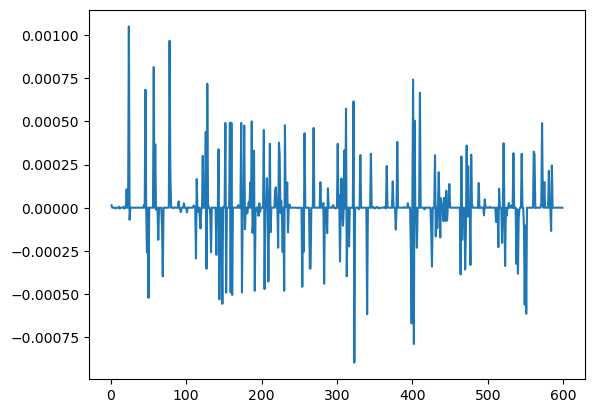

In [ ]:
plt.plot(full_book_df[full_book_df["time_id"] == 5]['log_return'])

An important feature will be the realized volatility over the 10 minute window. We can compute this by taking
$$
    \sqrt{\sum_t r_t^2},
$$
where $r_t$ is the log return from time $t$ to $t+1$. I'll also add some basic features: max price, min price, average price, average `bid_size1/2`, average `ask_size1/2`, etc. See the code for details. The `lambda` functions are being used to compute volatility, and the mean/std/max of the gaps between orders in the trade dataframe.

In [ ]:
book_features_df = book_df.groupby('time_id').aggregate(
    vol = pd.NamedAgg('log_return', lambda x: np.sqrt(sum(a*a for a in x))), # anonymous function to compute vol from log returns
    mean_wap = pd.NamedAgg('wap', 'mean'),
    min_wap = pd.NamedAgg('wap', 'min'),
    max_wap = pd.NamedAgg('wap', 'max'),
    mean_bid1 = pd.NamedAgg('bid_size1', 'mean'),
    mean_bid2 = pd.NamedAgg('bid_size2', 'mean'),
    mean_ask1 = pd.NamedAgg('ask_size1', 'mean'),
    mean_ask2 = pd.NamedAgg('ask_size2', 'mean'),
    min_bid1 = pd.NamedAgg('bid_size1', 'min'),
    min_ask1 = pd.NamedAgg('ask_size1', 'min'),
)

trade_features_df = trade_df.groupby('time_id').aggregate(
    avg_gap = pd.NamedAgg('seconds_in_bucket', lambda x: np.mean(np.diff(x))),
    std_gap = pd.NamedAgg('seconds_in_bucket', lambda x: np.std(np.diff(x))),
    max_gap = pd.NamedAgg('seconds_in_bucket', lambda x: np.max(np.diff(x))),
    sum_size = pd.NamedAgg('size', 'sum'),
    max_size = pd.NamedAgg('size', 'max'),
    sum_orders = pd.NamedAgg('order_count', 'sum'),
    max_orders = pd.NamedAgg('order_count', 'max'),
)

features_df = book_features_df.join(trade_features_df, on='time_id')
features_df.head()

,vol,mean_wap,min_wap,max_wap,mean_bid1,mean_bid2,mean_ask1,mean_ask2,min_bid1,min_ask1,avg_gap,std_gap,max_gap,sum_size,max_size,sum_orders,max_orders
time_id,,,,,,,,,,,,,,,,,
5,0.004499,1.003733,1.001443,1.004920,78.514950,81.142857,74.076412,89.737542,1,1,14.461538,12.497889,53,3179,499,110,12
11,0.001204,1.000240,0.999700,1.000834,149.688442,95.824121,71.000000,95.221106,1,1,19.551724,14.425997,56,1289,280,57,6
16,0.002369,0.999541,0.997224,1.000878,96.593583,115.010695,131.256684,73.449198,2,1,22.500000,18.973666,60,2161,391,68,8
31,0.002574,0.998819,0.997447,1.000412,112.537815,69.319328,120.974790,130.294118,1,2,40.928571,31.449425,107,1962,450,59,15
62,0.001894,0.999616,0.999231,1.000159,120.074286,88.142857,88.954286,47.285714,1,1,27.047619,17.080973,64,1791,341,89,17


Now let's add the Fourier transforms. We'll do PCA on top of this. The benefit of the Fourier transform is to make things shift-independent. So if a pattern happens at times 100-110, the same pattern at times 220-230 can get picked up. To do this, I'm going to put the dataframe into a numpy tensor so that we can do the Fourier transform in parallel. I'll leave it in the tensor for now for the sake of PCA.

In [ ]:
num_times = len(full_book_df['time_id'].unique())
num_seconds = len(full_book_df['seconds_in_bucket'].unique())
# the below could be useful
# original_col_names = list(full_book_df.columns)
# fourier_col_names = ["fft_" + name for name in original_col_names if name not in ('time_id', 'seconds_in_bucket')]
# new_col_names = original_col_names + fourier_col_names

book_tensor = full_book_df.drop(['time_id', 'seconds_in_bucket'], axis=1).to_numpy(dtype='float').reshape(num_times, num_seconds, -1)
fourier = np.fft.fft(book_tensor, axis=1)

# now fourier has complex entries. This isn't so nice for working with, so we'll split the complex numbers into real and imaginary
real, imag = np.real(fourier), np.imag(fourier)
fourier = np.concatenate([real, imag], axis=-1)
print(f"Fourier shape: {fourier.shape}. This is datapoints, timesteps, features. Features has doubled since we have real + imaginary")

Fourier shape: (3830, 599, 20). This is datapoints, timesteps, features. Features has doubled since we have real + imaginary


At this point, if we do PCA, we'll end up leaking data from the validation set. We also need to standardize our variables (again, on the training set only). So we really need to do some train/test split.

In [ ]:
train_proportion = .8
train_cutoff_index = int(train_proportion*fourier.shape[0])

fourier_train, fourier_test = np.split(fourier, [train_cutoff_index,])
train_mean = np.mean(fourier_train, axis=(0, 1))
train_std = np.std(fourier_train, axis=(0, 1))
normalized_train = (fourier_train-train_mean)/train_std
# we use the train_std and train_mean since that's what we do PCA on.
normalized_fourier = (fourier-train_mean)/train_std

Now we can run PCA on the train dataset. It takes my computer about 10 seconds, so it's not too slow. If this runs out of memory, we can switch to incremental PCA. I'll keep 10 dimensions (10 was selected by an elbow method).

In [ ]:
n_components = 10
fourier_pca = sklearn.decomposition.PCA(n_components)
fourier_pca.fit(normalized_train.reshape([normalized_train.shape[0], -1]))

# if we want to visualize the amount of variance explained, we can increase n_components and then plot the following
# plt.plot(fourier_pca.explained_variance_ratio_)

PCA(n_components=10)

Finally, we want to capture these components as features.

In [ ]:
pca_features = fourier_pca.transform(normalized_fourier.reshape([normalized_fourier.shape[0], -1]))

indices = full_book_df['time_id'].unique().reshape(-1, 1)
train_indices = indices[:train_cutoff_index].reshape(-1, 1)
test_indices = indices[train_cutoff_index:].reshape(-1, 1)

pca_col_names = ['time_id'] + ['pca_' + str(i) for i in range(n_components)]
pca_features_df = pd.DataFrame(data=np.concatenate((indices, pca_features), axis=1),  columns=pca_col_names)

# change time_id back to integer and make it an index
pca_features_df = pca_features_df.astype({'time_id': int})
pca_features_df = pca_features_df.set_index('time_id')

We can combine this with the features we found earlier. Then we'll split into train and test (again).

In [ ]:
features_df = features_df.join(pca_features_df)
train_df = features_df.iloc[:train_cutoff_index, :]
test_df  = features_df.iloc[train_cutoff_index:, :]

target_train_df = target_df.iloc[:train_cutoff_index, :]
target_test_df = target_df.iloc[train_cutoff_index:, :]

Now `train_df` and `test_df` contain all the PCA features and the handcrafted features. The corresponding `target_train_df` and `target_test_df` contain the volatility that we actually want to predict. Next, we implement the GMM, which can give class probabilities as a feature.

In [ ]:
max_components = 10  # Adjust the max number of components as desired
component_range = range(1, max_components+1)

# Initialize BIC scores
bic_scores = []

# Iterate over different values of n_components
for n in component_range:
    # Create and fit the GMM model
    gmm = GaussianMixture(n_components=n)
    gmm.fit(train_df)

    # Calculate the BIC score
    bic = gmm.bic(train_df)

    # Store the BIC score
    bic_scores.append(bic)

# Find the optimal number of components that minimizes BIC
gmm_num_components = component_range[np.argmin(bic_scores)]
print("Optimal number of n components:", gmm_num_components)

Optimal number of n components: 4


Now that we have the optimal number of components, we can fit. Then we'll predict (on the test and train set, to get features) and add these probabilities to our features. We'll also drop one of the cluster probabilities from the feature list, since the final probability can just be computed from the others, since the probabilities must sum to one.

In [ ]:
gmm = GaussianMixture(n_components=gmm_num_components)
gmm.fit(train_df)
probabilities = gmm.predict_proba(features_df)
reduced_probabilities = np.delete(probabilities, 0, axis=1)

indices = full_book_df['time_id'].unique().reshape(-1, 1)

gmm_col_names = ['time_id'] + ['gmm_' + str(i) for i in range(gmm_num_components-1)]
gmm_features_df = pd.DataFrame(data=np.concatenate((indices, reduced_probabilities), axis=1),  columns=gmm_col_names)

# change time_id back to integer and make it an index
gmm_features_df = gmm_features_df.astype({'time_id': int})
gmm_features_df = gmm_features_df.set_index('time_id')

Finally, combine all features into a single dataframe. Split into test and train as before.

In [ ]:
features_df = features_df.join(gmm_features_df)
train_df = features_df.iloc[:train_cutoff_index, :]
test_df  = features_df.iloc[train_cutoff_index:, :]
features_df.head()

,vol,mean_wap,min_wap,max_wap,mean_bid1,mean_bid2,mean_ask1,mean_ask2,min_bid1,min_ask1,...,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,gmm_0,gmm_1,gmm_2
time_id,,,,,,,,,,,,,,,,,,,,,
5,0.004499,1.003733,1.001443,1.004920,78.514950,81.142857,74.076412,89.737542,1,1,...,-7.567207,0.418956,1.347541,9.054175,2.869035,-0.725231,4.296136,9.714769e-12,2.263983e-09,1.0
11,0.001204,1.000240,0.999700,1.000834,149.688442,95.824121,71.000000,95.221106,1,1,...,1.027524,10.715674,-3.605742,-2.105826,-3.541638,5.773063,-5.867865,9.303544e-11,6.756414e-11,1.0
16,0.002369,0.999541,0.997224,1.000878,96.593583,115.010695,131.256684,73.449198,2,1,...,-16.664226,-4.073524,0.717971,-10.536809,5.529174,4.430600,4.780051,9.999999e-01,0.000000e+00,0.0
31,0.002574,0.998819,0.997447,1.000412,112.537815,69.319328,120.974790,130.294118,1,2,...,3.725221,-2.485620,-6.737938,-8.610035,6.890306,7.900675,12.525301,8.059945e-03,9.919400e-01,0.0
62,0.001894,0.999616,0.999231,1.000159,120.074286,88.142857,88.954286,47.285714,1,1,...,0.212663,13.007613,7.270283,1.481423,-1.502187,8.476422,-4.481147,7.592050e-10,2.749528e-08,1.0


Initialize the Random Forest model. We are using the RandomForestRegressor class from sklearn.ensemble module.

In [ ]:
rf = RandomForestRegressor(random_state=42)

Define the grid of hyperparameters to search. We define a dictionary where the keys are the names of the hyperparameters we want to tune, and the values are lists of the values we want to try out.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

Set up the grid search. We are using the GridSearchCV class from sklearn.model_selection module. This class performs an exhaustive search over the specified parameter values for an estimator.

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

Train the model. We are fitting the grid search object to the training data. This will perform the grid search and fit the best model to the data.

In [ ]:
grid_search.fit(train_df, target_train_df['target'])

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

Print the best parameters. We are printing the best hyperparameters found by the grid search.

In [ ]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


Make predictions with the best model. We are getting the best estimator found by the grid search and using it to make predictions on the testing data.


In [ ]:
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(test_df)

Calculate RMSE.


In [ ]:
rmse = np.sqrt(mean_squared_error(target_test_df['target'], predictions))
print("RMSE: ", rmse)

RMSE:  0.0013565968871066935


Calculate MAE.


In [ ]:
mae = mean_absolute_error(target_test_df['target'], predictions)
print("MAE: ", mae)

MAE:  0.0009012320198245584


Calculate R-squared. This metric provides an indication of the goodness of fit of the model.


In [ ]:
r2 = r2_score(target_test_df['target'], predictions)
print("R-squared: ", r2)

R-squared:  0.7134447144195071
